In [1]:
import nilearn
from nilearn.image.image import mean_img


from nilearn.masking import compute_epi_mask
from nilearn.plotting import plot_roi


from nilearn.plotting import plot_stat_map

import random

from nilearn.input_data import NiftiLabelsMasker # NiftiMasker


import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:

img = '/users2/local/Venkatesh/HBN/CPAC_preprocessed/sub-NDARAD481FXF_ses-1/functional_to_standard/_scan_rest/_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1_C-S-1+2-FD-J0.5/bandpassed_demeaned_filtered_antswarp.nii.gz'
mask = '/users2/local/Venkatesh/HBN//CPAC_preprocessed/sub-NDARAD481FXF_ses-1/functional_brain_mask_to_standard/_scan_rest/sub-NDARAD481FXF_task-rest_bold_calc_resample_volreg_mask_antswarp.nii.gz'
# img_to_plot = mean_img(img)


# 1. Check if "Standard" is an MNI space -- Checking the provided mask
# 2. Checking the time-series, the data distribution, voxel-level
# 3. Glasser Parcellation
# 4. The data distribution, ROI-level
# 5. Checking the significance of pre-processing


# 1. "Standard" is an MNI space ? finding it here usign mask as the ROI 

/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


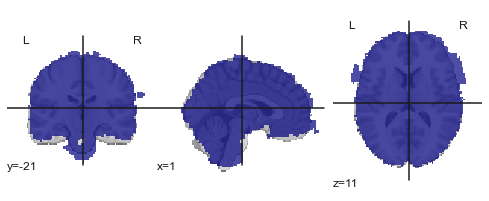

In [3]:
plot_roi(mask)

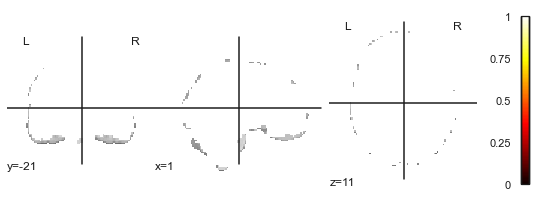

In [4]:

plot_stat_map(mask)

# Loading data voxel-level 

(array([10., 13., 26., 62., 84., 67., 81., 50., 19.,  8.]),
 array([-796.02873506, -643.87020819, -491.71168131, -339.55315443,
        -187.39462756,  -35.23610068,  116.9224262 ,  269.08095307,
         421.23947995,  573.39800683,  725.5565337 ]),
 <BarContainer object of 10 artists>)

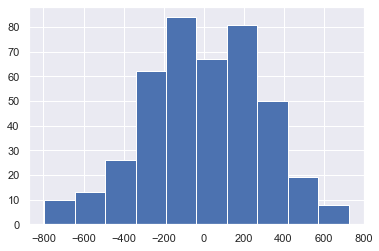

In [5]:
img_voxels = nilearn.input_data.NiftiMasker(mask).fit_transform(img)

plt.hist(img_voxels[:,random.randint(1,236454)])

# 3. Glasser Parcellation

In [6]:
# import yaml

# loc_for_pipeline = '/users2/local/Venkatesh/HBN/CPAC_preprocessed/pipeline.yml'
# with open(loc_for_pipeline, "r") as stream:
#             print(yaml.safe_load(stream))


path_Glasser = '/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'


# Glasser is a reference map for regions in the brain. It splits the brain into 360 regions.
glassermasker = NiftiLabelsMasker(labels_img=path_Glasser,mask_img=mask,standardize=True)
parcellated = glassermasker.fit_transform(img)

# 4. The distribution at ROI-level

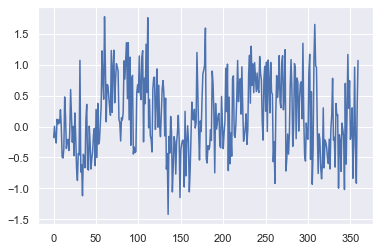

In [7]:
plt.plot(parcellated[0,:])

(array([ 32.,  63., 102., 116.,  65.,  32.,   5.,   2.,   0.,   3.]),
 array([-2.09701124, -1.42647984, -0.75594843, -0.08541703,  0.58511437,
         1.25564577,  1.92617718,  2.59670858,  3.26723998,  3.93777139,
         4.60830279]),
 <BarContainer object of 10 artists>)

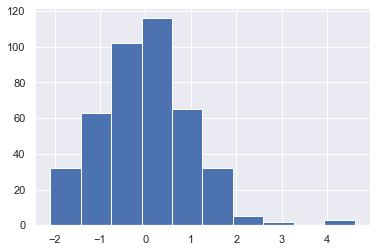

In [8]:

plt.hist((parcellated[:,random.randint(1,359)]))

In [9]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([parcellated])[0]# 25 indiv 


#for later: tangent group-level
#

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation

rois = np.load('/homes/v20subra/S4B2/GSP/hcp/regions.npy')
roi_labels = [rois[i][1] for i in range(360)]

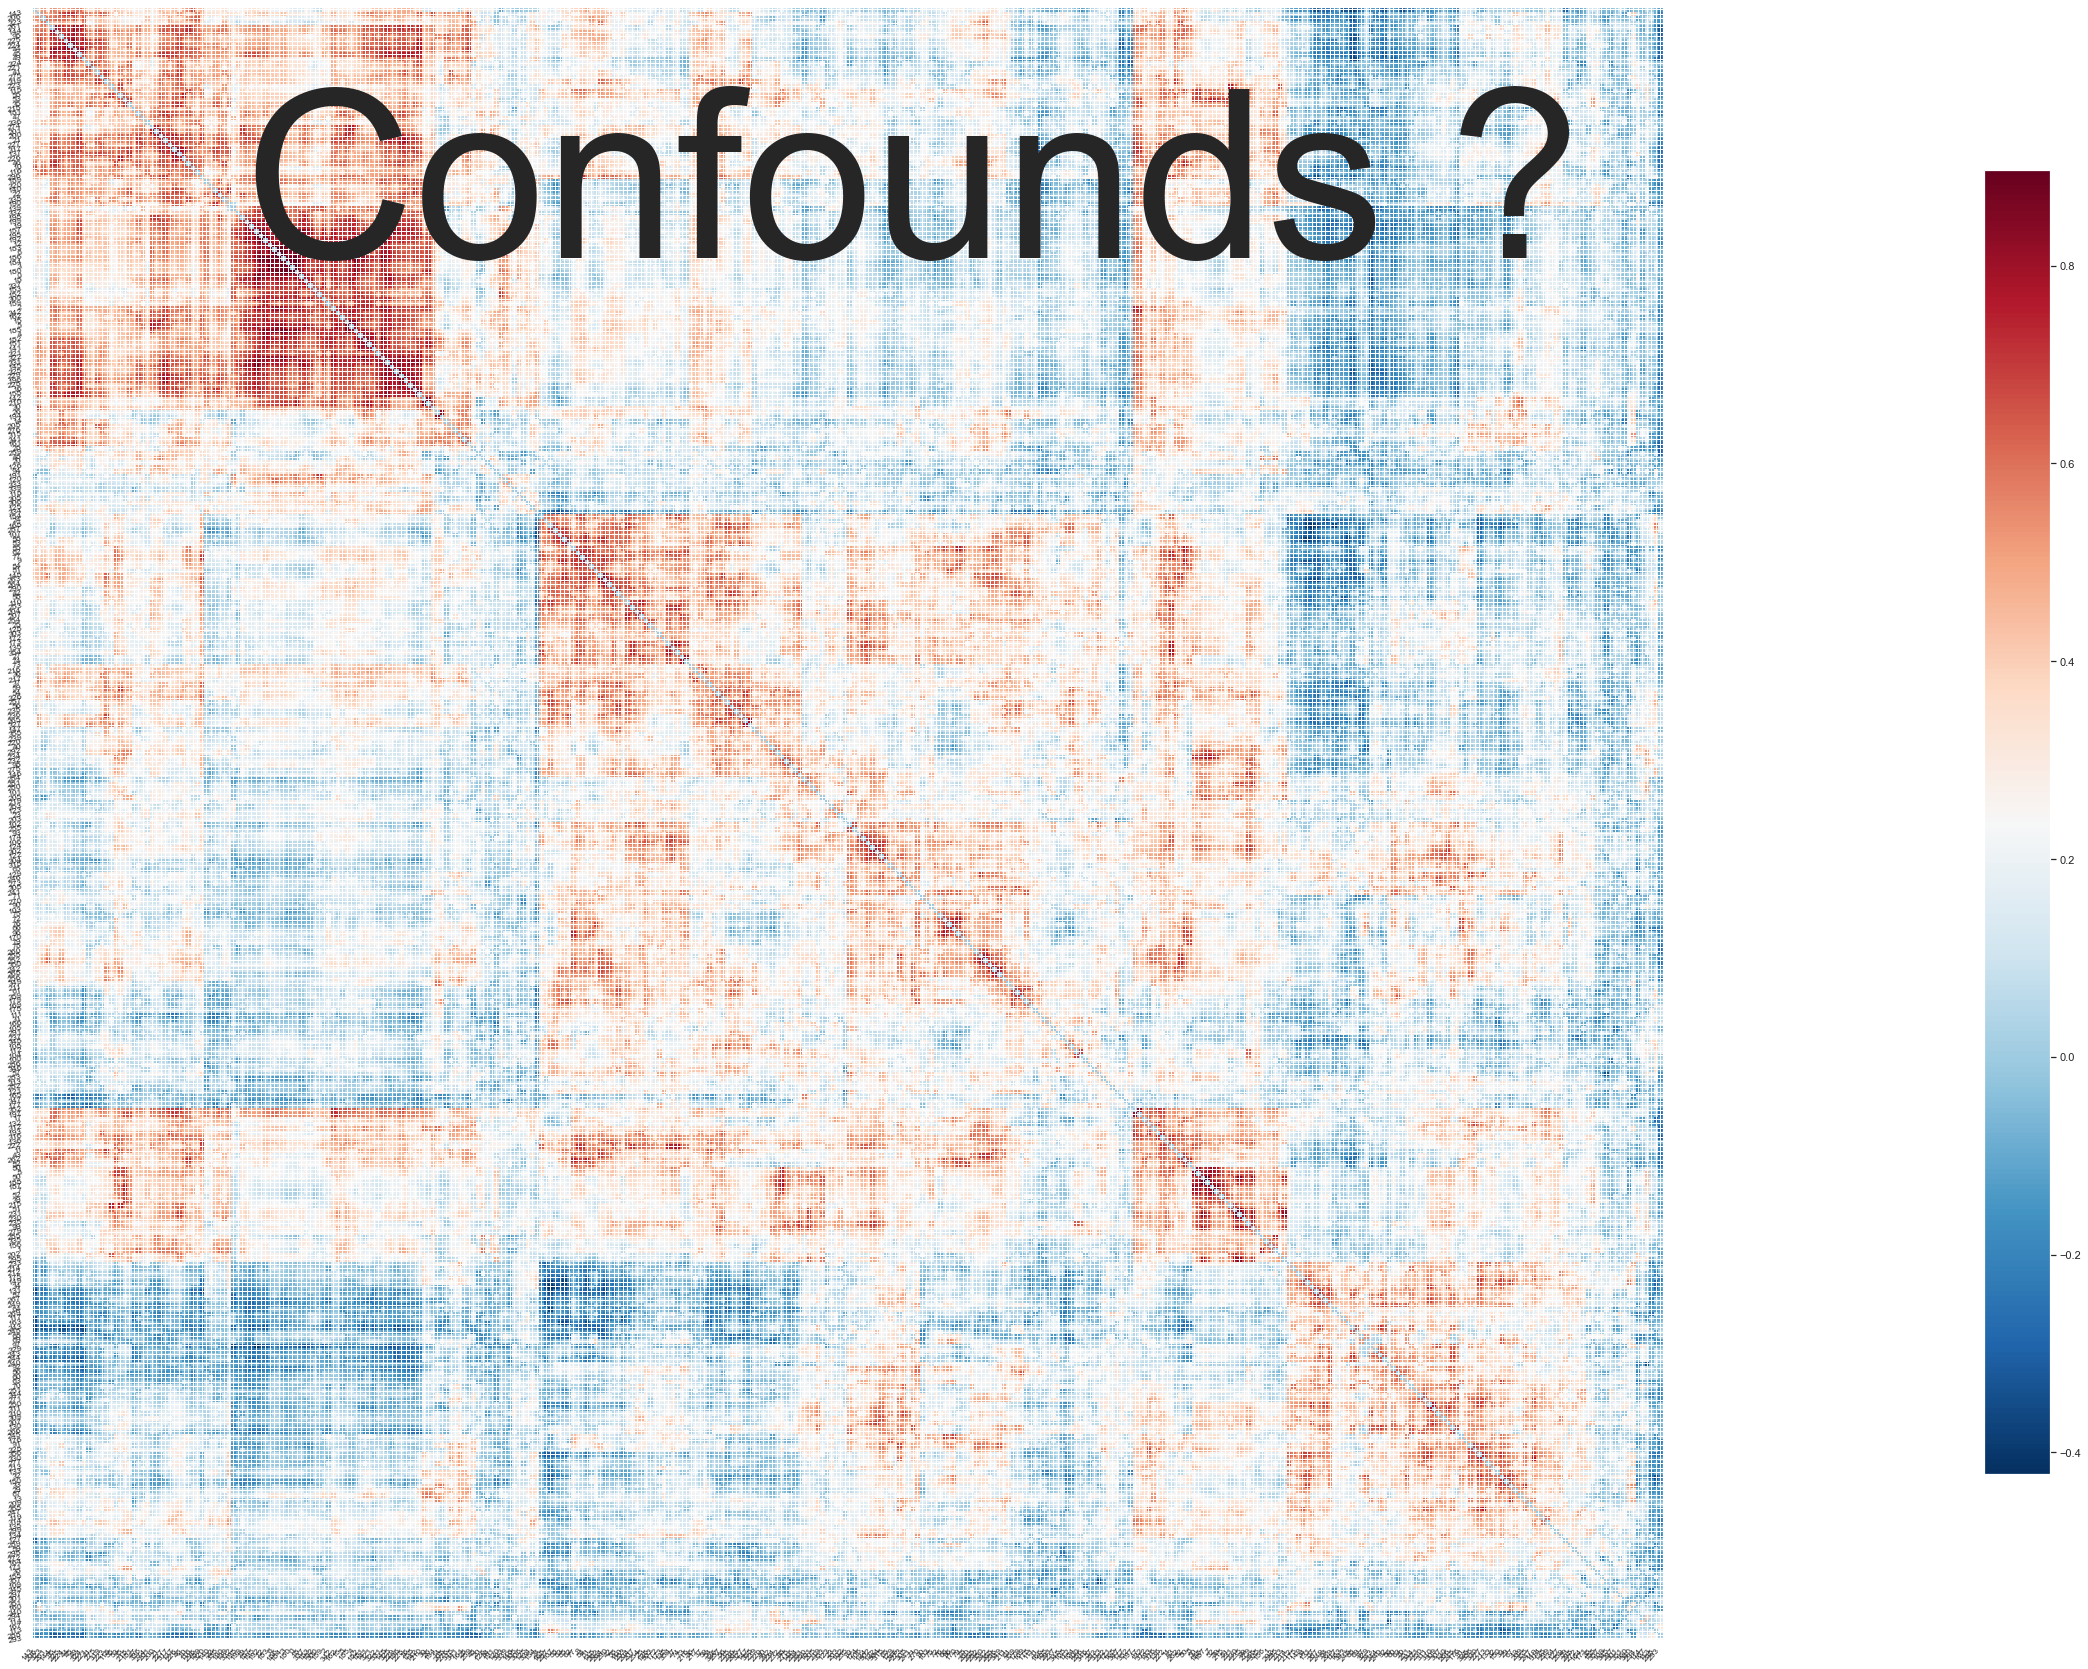

In [17]:
l = np.arange(360)
plotting.plot_matrix(correlation_matrix, figure=(55, 30), labels=l, title="Confounds ?",
                     reorder=True)
                     #nilearn tuto for neigh voxels -correlation --
                     #seed-based
                     #niftisphere masker

                     

# Code for 8-NN findings

In [17]:
import pickle
import torch


pickle_file = '/homes/v20subra/S4B2/GSP/MMP_RSFC_brain_graph_fullgraph.pkl'

with open(pickle_file, 'rb') as f:
        [connectivity]= pickle.load(f)
connectivity.shape
np.fill_diagonal(connectivity,0)

graph = torch.from_numpy(connectivity)
knn_graph = torch.zeros(graph.shape)
for i in range(knn_graph.shape[0]):
    graph[i,i] = 0
    best_k = torch.sort(graph[i,:])[1][-8:]
    knn_graph[i, best_k] = 1
    knn_graph[best_k, i] = 1
    
degree = torch.diag(torch.pow(knn_graph.sum(dim = 0), -0.5))
laplacian = torch.eye(graph.shape[0]) - torch.matmul(degree, torch.matmul(knn_graph, degree))
values, eigs = torch.linalg.eigh(laplacian)

weight_matrix_after_NN = torch.matmul(degree, torch.matmul(knn_graph, degree))

In [18]:
from scipy import io as sio
from pygsp import graphs
from seaborn.utils import axis_ticklabels_overlap
from scipy.sparse import csr_matrix

def graph_setup(laplacian):
    path_Glasser='/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'
    res_path=''
    coordinates = sio.loadmat('/homes/v20subra/S4B2/GSP/Glasser360_2mm_codebook.mat')['codeBook'] 

    # Load structural connectivity matrix
    # connectivity = sio.loadmat('/homes/v20subra/S4B2/GSP/SC_avg56.mat')['SC_avg56']
    pickle_file = '/homes/v20subra/S4B2/GSP/MMP_RSFC_brain_graph_fullgraph.pkl'

    G=graphs.Graph(weight_matrix_after_NN,gtype='HCP subject',lap_type=laplacian,coords=coordinates) 
    G.set_coordinates('spring')
    print('{} nodes, {} edges'.format(G.N, G.Ne))


    return G

G = graph_setup(laplacian='normalized')

###############################
####Decomposing into eigenmodes
###############################
G.compute_fourier_basis()

360 nodes, 2098 edges


AssertionError: 

# Eigenvalues

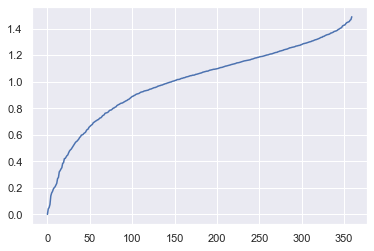

In [183]:
plt.plot(G.e)

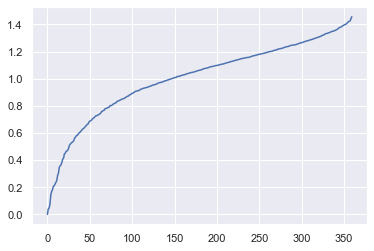

In [204]:
plt.plot(values.numpy())

In [37]:
np.where(np.array(roi_labels)=='Default')

(array([ 11,  24,  25,  27,  73,  74,  78,  80, 122, 124, 127, 128, 138,
        171, 191, 205, 254, 258, 302, 304, 308, 318, 351]),)

# 

In [14]:
path_Glasser = '/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz'

from nilearn.regions import signals_to_img_labels  
# load nilearn label masker for inverse transform
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
from nilearn import datasets
from os.path import join as opj
import matplotlib.pyplot as plt



mnitemp = fetch_icbm152_2009()
mask_mni=image.load_img(mnitemp['mask'])
glasser_atlas=image.load_img(path_Glasser)
signal=np.expand_dims(correlation_matrix[229], axis=0) # add dimension 1 to signal array

U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])


In [16]:
np.shape(correlation_matrix[229])

(360, 360)

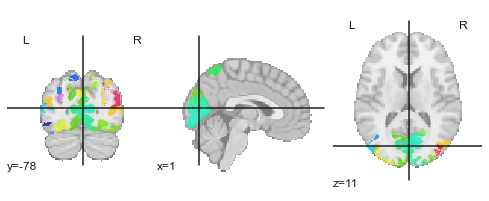

In [15]:
plot_roi(U0_brain)

In [12]:
parcellated

array([[-0.17642376,  0.00549244, -0.186848  , ..., -0.91673971,
         0.32805311,  1.07134475],
       [-0.16823835, -0.28775648,  0.24242201, ..., -0.79617154,
         0.24033597,  1.40953443],
       [-0.14134029, -0.55950205,  0.67858668, ..., -0.59546072,
         0.30398265,  1.50970023],
       ...,
       [ 0.75325123, -0.96734658,  0.1710572 , ...,  0.92292592,
        -2.50514419, -1.74913119],
       [ 0.79274579, -0.5490707 , -0.10328249, ...,  0.72729047,
        -2.69037125, -1.66970235],
       [ 0.70278742,  0.05700673, -0.22939183, ...,  0.29757157,
        -2.21361982, -1.14211598]])